In [1]:
import matplotlib.pyplot as plt
from keras import Model
from keras.layers import Dense
from keras_pandas.Automater import Automater
from keras import backend as K
from  sklearn.utils import resample
import functools
import pandas
import tensorflow as tf
import numpy as np
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

/home/fuckme/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df=pandas.read_csv('Logs/stats.csv')
print(len(df))

2596153


In [3]:
df["Opponent_Percent_Change"] = df["Opponent_Percent_Change"].shift(-1)
df["AI_Percent_Change"] = df["AI_Percent_Change"].shift(-1)
df.drop(len(df)-1,inplace=True)

In [4]:
df['target'] = df.apply (lambda row: row["Opponent_Percent_Change"]>0,axis=1)
print(len(df[(df['target'] > 0)]),len(df))

8517 2596152


In [5]:
df=df.drop(columns=['AI_Action', 'Opponent_Action', 'Buttons Pressed', 'Notes', 'Frame Process Time'])

In [6]:
df_majority = df[df.target==False]
df_minority = df[df.target==True]
print(len(df_majority),len(df_minority))

2587635 8517


In [7]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=123) # reproducible results
df = pandas.concat([df_majority_downsampled, df_minority]).sample(frac=1)
df.reset_index(drop=True,inplace=True)

In [8]:
categorical_vars=["Opponent_Facing","AI_Facing","target"]
numerical_vars=["Frame","Opponent_x","Opponent_y","AI_x","AI_y",
                "Opponent_Action_Num","AI_Action_Num","AI_Action_Frame",
                "Opponent_Action_Frame","Opponent_Jumps_Left", "AI_Jumps_Left",
                "Opponent_Stock","AI_Stock",
                "Opponent_Percent","AI_Percent","Buttons_Pressed_Converted"]
auto=Automater(categorical_vars=categorical_vars,numerical_vars=numerical_vars,response_var="target")

In [9]:
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [10]:
X, y = auto.fit_transform(df)

/home/fuckme/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fuckme/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fuckme/.local/lib/python3.5/site-packages/keras_pandas/constants.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  transformed = input_dataframe[variable].as_matrix()
/home/fuckme/.local/lib/python3.5/site-packages/keras_pandas/constants.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  transformed = input_dataframe[variable].as_matrix()


In [11]:
sess = tf.Session()
K.set_session(sess)
K.set_learning_phase(0)  # all new operations will be in test mode from now on
model_version = "2"
seed = 7
np.random.seed(seed)

In [12]:
# Start model with provided input nub
x = auto.input_nub

# Fill in your own hidden layers
x = Dense(32)(x)
x = Dense(8, activation='relu')(x)
#x = Dense(32)(x)

# End model with provided output nub
x = auto.output_nub(x)
model = Model(inputs=auto.input_layers, outputs=x)


In [13]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)
model.compile(optimizer='Adam', loss=auto.loss, metrics=['accuracy',precision,recall])

In [14]:
# Train model
history=model.fit(X, y, epochs=100,validation_split=.2,verbose=1)

Train on 14813 samples, validate on 3704 samples
Epoch 1/100
14813/14813 [==============================] - 1s 62us/step - loss: 0.5382 - acc: 0.7199 - precision: 0.4536 - recall: 0.9978 - val_loss: 0.5000 - val_acc: 0.7581 - val_precision: 0.4603 - val_recall: 1.0000
Epoch 2/100
14813/14813 [==============================] - 1s 58us/step - loss: 0.4629 - acc: 0.7882 - precision: 0.4598 - recall: 1.0000 - val_loss: 0.4642 - val_acc: 0.7905 - val_precision: 0.4601 - val_recall: 1.0000
Epoch 3/100
14813/14813 [==============================] - 1s 55us/step - loss: 0.4388 - acc: 0.8097 - precision: 0.4599 - recall: 1.0000 - val_loss: 0.4501 - val_acc: 0.7986 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 4/100
14813/14813 [==============================] - 1s 59us/step - loss: 0.4249 - acc: 0.8147 - precision: 0.4598 - recall: 1.0000 - val_loss: 0.4352 - val_acc: 0.8121 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 5/100
14813/14813 [==============================] - 1s 56us/step

Epoch 38/100
14813/14813 [==============================] - 1s 57us/step - loss: 0.3222 - acc: 0.8725 - precision: 0.4599 - recall: 1.0000 - val_loss: 0.3299 - val_acc: 0.8647 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 39/100
14813/14813 [==============================] - 1s 55us/step - loss: 0.3217 - acc: 0.8741 - precision: 0.4600 - recall: 1.0000 - val_loss: 0.3270 - val_acc: 0.8658 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 40/100
14813/14813 [==============================] - 1s 56us/step - loss: 0.3199 - acc: 0.8713 - precision: 0.4600 - recall: 1.0000 - val_loss: 0.3275 - val_acc: 0.8656 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 41/100
14813/14813 [==============================] - 1s 58us/step - loss: 0.3190 - acc: 0.8724 - precision: 0.4600 - recall: 1.0000 - val_loss: 0.3313 - val_acc: 0.8607 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 42/100
14813/14813 [==============================] - 1s 55us/step - loss: 0.3173 - acc: 0.8751 - precision: 0

14813/14813 [==============================] - 1s 58us/step - loss: 0.3076 - acc: 0.8756 - precision: 0.4600 - recall: 1.0000 - val_loss: 0.3150 - val_acc: 0.8669 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 76/100
14813/14813 [==============================] - 1s 55us/step - loss: 0.3075 - acc: 0.8775 - precision: 0.4600 - recall: 1.0000 - val_loss: 0.3178 - val_acc: 0.8674 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 77/100
14813/14813 [==============================] - 1s 56us/step - loss: 0.3065 - acc: 0.8776 - precision: 0.4600 - recall: 1.0000 - val_loss: 0.3148 - val_acc: 0.8674 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 78/100
14813/14813 [==============================] - 1s 54us/step - loss: 0.3071 - acc: 0.8777 - precision: 0.4600 - recall: 1.0000 - val_loss: 0.3155 - val_acc: 0.8704 - val_precision: 0.4600 - val_recall: 1.0000
Epoch 79/100
14813/14813 [==============================] - 1s 56us/step - loss: 0.3055 - acc: 0.8786 - precision: 0.4600 - recal

In [29]:
json_string = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('my_model_weights.h5')    

In [15]:
labels=["True","False"]
y=auto.input_nub

In [20]:
classification_inputs

name: "concatenate_inputs/concat:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
  dim {
    size: -1
  }
}

In [22]:
values, indices = tf.nn.top_k(y, len(labels))
table =tf.contrib.lookup.index_to_string_table_from_tensor(tf.constant(labels))
prediction_classes = table.lookup(tf.to_int64(indices))

classification_inputs = tf.saved_model.utils.build_tensor_info(auto.input_nub)
classification_outputs_classes = tf.saved_model.utils.build_tensor_info(prediction_classes)
classification_outputs_scores = tf.saved_model.utils.build_tensor_info(values)

classification_signature = tf.saved_model.signature_def_utils.classification_signature_def(
    examples=classification_inputs,
    classes=prediction_classes,
    scores=classification_outputs_scores
)
prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def({"inputs": x}, {"prediction":y})

ValueError: Classification examples must be a string Tensor.

In [ ]:
valid_prediction_signature = tf.saved_model.signature_def_utils.is_valid_signature(prediction_signature)
valid_classification_signature = tf.saved_model.signature_def_utils.is_valid_signature(classification_signature)

if(valid_prediction_signature == False):
    raise ValueError("Error: Prediction signature not valid!")

if(valid_classification_signature == False):
    raise ValueError("Error: Classification signature not valid!")

In [ ]:
builder = saved_model_builder.SavedModelBuilder('./'+model_version)
legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

# Add the meta_graph and the variables to the builder
builder.add_meta_graph_and_variables(
      sess, [tag_constants.SERVING],
      signature_def_map={
           'predict-smash':
               prediction_signature,
           signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
              classification_signature,
      },
      legacy_init_op=legacy_init_op)
# save the graph
builder.save()

In [29]:
classfication_signature = tf.saved_model.signature_def_utils.classification_signature_def(examples=model.input,classes=model.output,scores=model.output)

ValueError: Classification examples must be a string Tensor.

In [15]:
print(history.history.keys())

dict_keys(['acc', 'val_loss', 'val_acc', 'precision', 'recall', 'loss', 'val_precision', 'val_recall'])


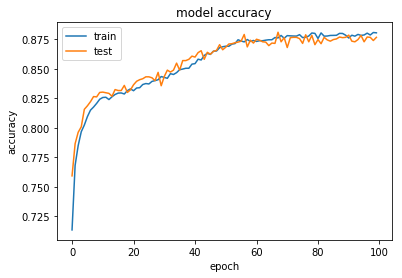

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# TODO: account for end of game
# Discount Factor Wait on this
for idx in reversed(df.index):
    print(idx, df.loc[idx, "AI_Percent_Change"])